# Cross-Section Plots for $\ell A_Z \rightarrow \ell' A_Z \varphi$

## Set-Up

In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#
import itertools

#For setting root path and accessing files
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
os.chdir('..') 
import h5py

#for caching cross-section values
from functools import lru_cache

from lepton_nucleus_collisions.utils.process import (process_run_card,
                                                     process_dcrossx,
                                                     read_dcrossx,
                                                     open_dcrossx,
                                                     lepton_idx
                                                    )
from lepton_nucleus_collisions.utils.lab_frame import lab_frame_distributions
from phys.constants import hc2_fbGeV2

Set up the colliders and their names:

In [2]:
colliders = ['E137', 'EIC_Gold', 'MuSIC', 'MuCol']
collider_colors = [colors[1], colors[0], colors[2], colors[3]]
collider_TeX = ['$\\textrm{E137}$','$\\textrm{EIC}$','$\\textrm{MuSIC}$','$\\textrm{MuBD}$']

color_dict = dict(zip(colliders, collider_colors))
TeX_dict = dict(zip(colliders, collider_TeX))
run_cards = [f'{collider}.txt' for collider in colliders]

Now, we create a method for extracting the cross-section from the hdf5 files and caching the result:

In [3]:
#cache
@lru_cache(maxsize=None)
def crossx(collider, params, units = 'pb'):
    file_name = f'lepton_nucleus_collisions/data/{collider}.h5'
    masses = process_run_card(f'{collider}.txt', 'masses')
    sig = np.array([open_dcrossx(file_name, params + (m,), 'SIG') for m in masses])
    if units == 'fb':
        return hc2_fbGeV2*sig
    if units == 'pb':
        return (hc2_fbGeV2/1000)*sig
    return sig

Finally, we create a method which plots the cross-section as a function of mass given the collider and a tuple of final-state parameters consisting of the final-state lepton, the type of final-state particle (vector or scalar), the momentum transfer cut-off, and the method used to compute the cross-section (exact, WW, or IWW). To encode potential PV-violation in the coupling, we allow input of a PV angle $\theta$. When set to None, the range of possible cross-sections reachable by varying $\theta$ is shaded in.

In [4]:
def plot_crossx(collider, params, PV_angle = None, ax = None, color = None, linestyle = 'solid', line_alpha = 1, fill_alpha = 1, units = 'pb', label = None):
    if not ax:
        ax = plt.gca()
    
    #colliders have a color by default
    if not color:
        color = color_dict[collider]
        
    conversion = 1 # by default, GeV^{-2}
    if units == 'fb':
        conversion = hc2_fbGeV2
    if units == 'pb':
        conversion = hc2_fbGeV2/1000
    
    file_name = f'lepton_nucleus_collisions/data/{collider}.h5'
    masses = np.array(process_run_card(f'{collider}.txt', 'masses'))
    sig = crossx(collider, params+(False,), units = units)
    sig_PV = sig + crossx(collider, params + (True,), units = units)
    
    if PV_angle:
        plt.plot(masses, np.cos(PV_angle)**2 * sig + np.sin(PV_angle)**2 * sig_PV, color = color, alpha = line_alpha, label = label)
        
    else:
        ax.fill_between(masses,
                        sig,
                        sig_PV,
                        color = color,
                        alpha = fill_alpha)

        ax.plot(masses,
                sig,
                color = color,
                linestyle = linestyle,
                alpha = line_alpha,
                label = label)

        rel_diff = np.abs((sig_PV - sig)/sig)
        
        ax.plot(masses[rel_diff > 0.05],
                sig_PV[rel_diff > 0.05],
                color = color,
                linestyle = linestyle,
                alpha = line_alpha)

##  Plotting the cross-sections at each collider:

To plot the cross-sections at each collider, we first define a method to plot the cross-section for each final-state lepton given a final-state particle type. Then, we define a method which sets these lepton plots side-by-side for a (pseudo-)scalar and (axial-)vector. For a given $t_{\rm cutoff}$ (default is $(1~{\rm GeV})^2$) and method (default is exact), this figure allows comparison of the total production cross-section of the particle $\varphi$ at each collider. 

In [5]:
def plot_leptons(collider,
                 particle_type,
                 t_cut_off = 1.0,
                 method = 'exact',
                 ax = None,
                 color = None,
                 units = 'pb'):
    if not ax:
        ax = plt.gca()
    
    linestyle = ['solid', 'dashed', 'dotted']
    for idx, lepton in enumerate(['e', 'mu', 'tau']):
        plot_crossx(collider,
                    (lepton, particle_type, t_cut_off, method),
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2,
                    units = units)
        
def compare_particle_types(colliders,
                           ax1,
                           ax2,
                           t_cut_off = 1.0,
                           method = 'exact',
                           ylim = (1e0,1e14),
                           xlim = (1e-3,1e2),
                           units = 'pb'):
    
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")
    
    params = ("scalar", t_cut_off, method)
    for collider in colliders:
        plot_leptons(collider, *params, ax = ax1)
        ax1.plot([1e16],
                 color = color_dict[collider],
                 linestyle = 'solid',
                 label = TeX_dict[collider])
        
    ax2.set_title("$\\textrm{(Axial-)Vector}$")
    
    params = ("vector", t_cut_off, method)        
    for collider in colliders:
        plot_leptons(collider, *params, ax = ax2)
        ax2.plot([1e16],
                 color = color_dict[collider],
                 linestyle = 'solid',
                 label = TeX_dict[collider])
    
    
    li = process_run_card(f'{collider}.txt', 'li')
    li = '\\' + li if li != 'e' else li
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow \\ell^- A_Z \\varphi)/g_{{{li}\\ell}}^2~[{{\\rm {units}}}]$')
    ax1.tick_params(which = 'both', direction = 'in')
    ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

    axes = [ax1, ax2]
    for ax in axes:
        ax.grid()
        
        ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        if ylim:
            ax.set_ylim(*ylim)
        if xlim:
            ax.set_xlim(*xlim)
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'solid',
                label = "$\\ell = e$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dashed',
                label = "$\\ell = \\mu$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dotted',
                label = "$\\ell = \\tau$")
        
        ax.legend(fancybox = False,
                  facecolor = 'white',
                  edgecolor = 'black',
                  framealpha = 1,
                  loc = 'upper right',
                  fontsize = 8,
                  borderpad = 0.6)
    return ax1, ax2

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/4023070987.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)


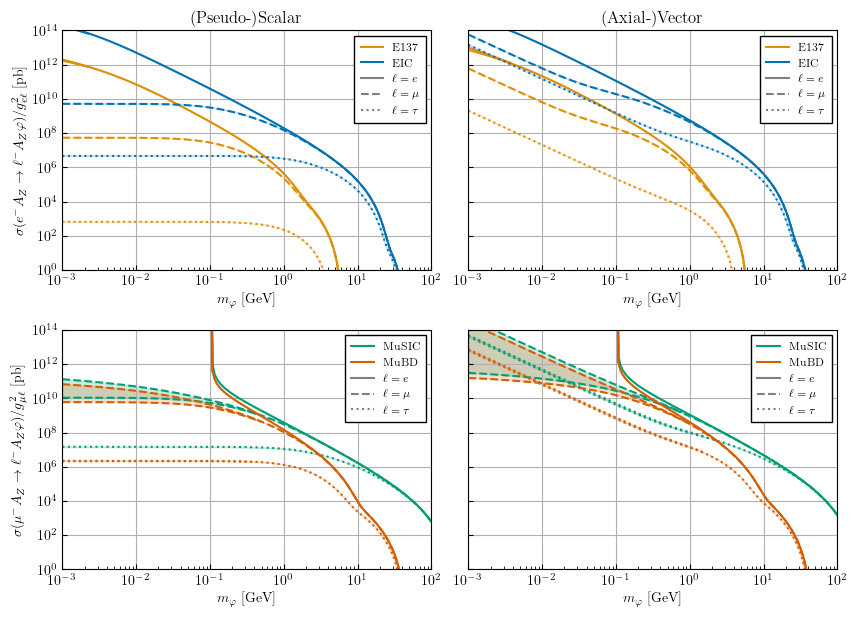

In [6]:
fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 2, wspace = 0.1, hspace = 0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax1, ax2 = compare_particle_types(['E137', 'EIC_Gold'], ax1, ax2)
ax3, ax4 = compare_particle_types(['MuSIC', 'MuCol'], ax3, ax4)
ax3.set_title(None)
ax4.set_title(None)

plt.savefig('figures/chapter4/production_crossx.pdf', format = 'pdf')

## Approximations

In [7]:
def relative_error(exact, approx):
    return np.abs(approx - exact)/np.abs(exact)

def plot_methods(collider,
                 lepton,
                 particle_type,
                 t_cut_off,
                 color = None,
                 ax = None,
                 units = 'pb'):
    if not ax:
        ax == plt.gca() 

    if not color:
        color = color_dict[collider]
        
        
    linestyle = ['solid', 'dashed', 'dotted']
    for idx, method in enumerate(['exact', 'WW', 'IWW']):
        plot_crossx(collider,
                    (lepton, particle_type, t_cut_off, method),
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2 if method=='exact' else 0.0,
                    units = units)
        
def plot_method_errors(collider,
                       lepton,
                       particle_type,
                       t_cut_off = 1.0,
                       ax = None,
                       color = None):
    if not ax:
        ax = plt.gca()
    
    if not color:
        color = color_dict[collider]
        
    params = (lepton, particle_type, t_cut_off)
    
    masses = process_run_card(f'{collider}.txt', 'masses')
    
    sig_exact = crossx(collider, params + ('exact',False))
    sig_exact_PV = sig_exact + crossx(collider, params + ('exact', True))

    sig_WW = crossx(collider, params + ('WW',False))
    sig_WW_PV = sig_WW + crossx(collider, params + ('WW', True))
    
    sig_IWW = crossx(collider, params + ('IWW',False))
    sig_IWW_PV = sig_IWW + crossx(collider, params + ('IWW', True))
    
    ax.plot(masses, relative_error(sig_exact, sig_WW), color = color, linestyle = 'dashed')
    ax.plot(masses, relative_error(sig_exact_PV, sig_WW_PV), color = color, linestyle = 'dashed')
    
    ax.plot(masses, relative_error(sig_exact, sig_IWW), color = color, linestyle = 'dotted')
    ax.plot(masses, relative_error(sig_exact_PV, sig_IWW_PV), color = color, linestyle = 'dotted')
    
def compare_methods(colliders,
                    lepton,
                    gs,
                    t_cut_off = 1.0,
                    ylim = (1e0,1e14),
                    error_ylim = (1e-6, 1e0),
                    xlim = (1e-3,1e2),
                    units = 'pb'):
        
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[2], sharex = ax1)
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")
    params = (lepton, 'scalar', t_cut_off)
    for collider in colliders:
        plot_methods(collider, *params, ax = ax1)
        plot_method_errors(collider, *params, ax = ax2)
        ax1.plot([1e16],
                 color = color_dict[collider],
                 linestyle = 'solid',
                 label = TeX_dict[collider])
        
    ax3 = fig.add_subplot(gs[1])
    ax4 = fig.add_subplot(gs[3], sharex = ax3)
    ax3.set_title("$\\textrm{(Axial-)Vector}$")
    
    params = (lepton, 'vector', t_cut_off)        
    for collider in colliders:
        plot_methods(collider, *params, ax = ax3)
        plot_method_errors(collider, *params, ax = ax4)
        ax3.plot([1e16],
                 color = color_dict[collider],
                 linestyle = 'solid',
                 label = TeX_dict[collider])
    
    ax1.tick_params(which = 'both', direction = 'in', labelbottom = False)
    ax2.tick_params(which = 'both', direction = 'in')
    ax3.tick_params(which = 'both', direction = 'in', labelbottom = False, labelleft = False)
    ax4.tick_params(which = 'both', direction = 'in', labelleft = False)
    
    li = process_run_card(f'{collider}.txt', 'li')
    li = '\\' + li if li != 'e' else li
    lf = '\\' + lepton if lepton != 'e' else lepton
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow {lf}^- A_Z \\varphi)/g_{{{li}{lf}}}^2~[{{\\rm {units}}}]$')
    ax2.set_ylabel('$\\textrm{rel. error}$')

    axes = [ax1, ax2, ax3, ax4]
    for idx, ax in enumerate(axes):
        ax.grid()
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if idx%2 == 0:
            if ylim:
                ax.set_ylim(*ylim)
                
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'solid',
                    label = "$\\textrm{exact}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dashed',
                    label = "$\\textrm{WW}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dotted',
                    label = "$\\textrm{IWW}$")
        
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'upper right',
                      fontsize = 8,
                      borderpad = 0.6)
            
        if idx%2 == 1:
            if error_ylim:
                ax.set_ylim(*error_ylim)
            if xlim:
                ax.set_xlim(*xlim)
            ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')            
            
    return axes

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/4023070987.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3190884567.py:2: RuntimeWarning: invalid value encountered in divide
  return np.abs(approx - exact)/np.abs(exact)


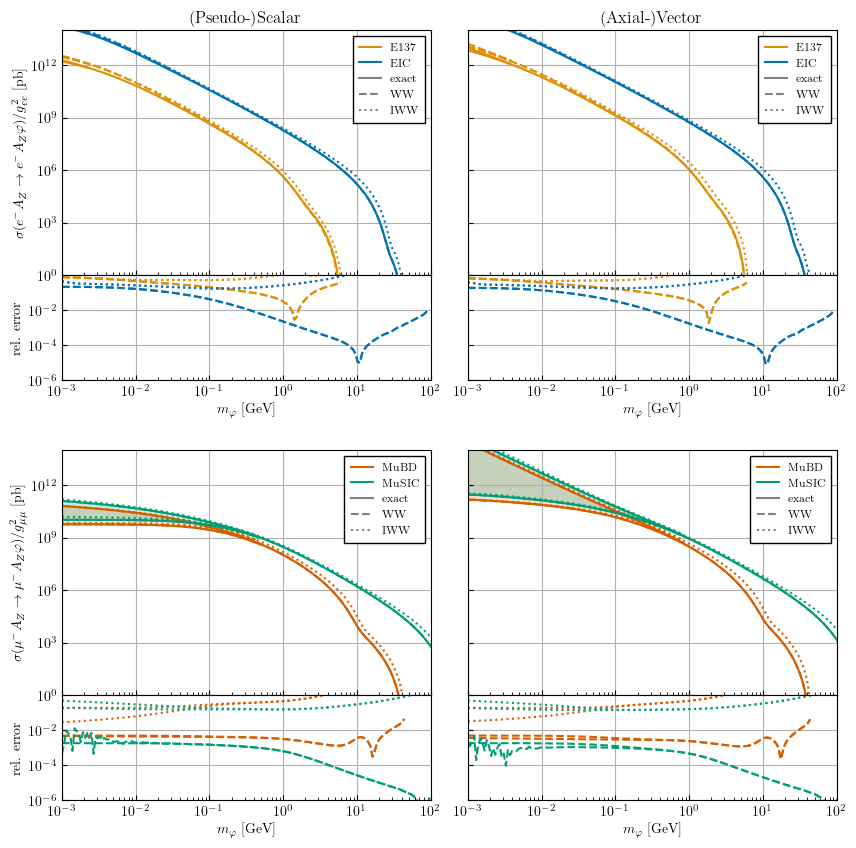

In [8]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods(['E137','EIC_Gold'], 'e', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods(['MuCol','MuSIC'], 'mu', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])
ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_diagonal.pdf')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/4023070987.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3190884567.py:2: RuntimeWarning: invalid value encountered in divide
  return np.abs(approx - exact)/np.abs(exact)


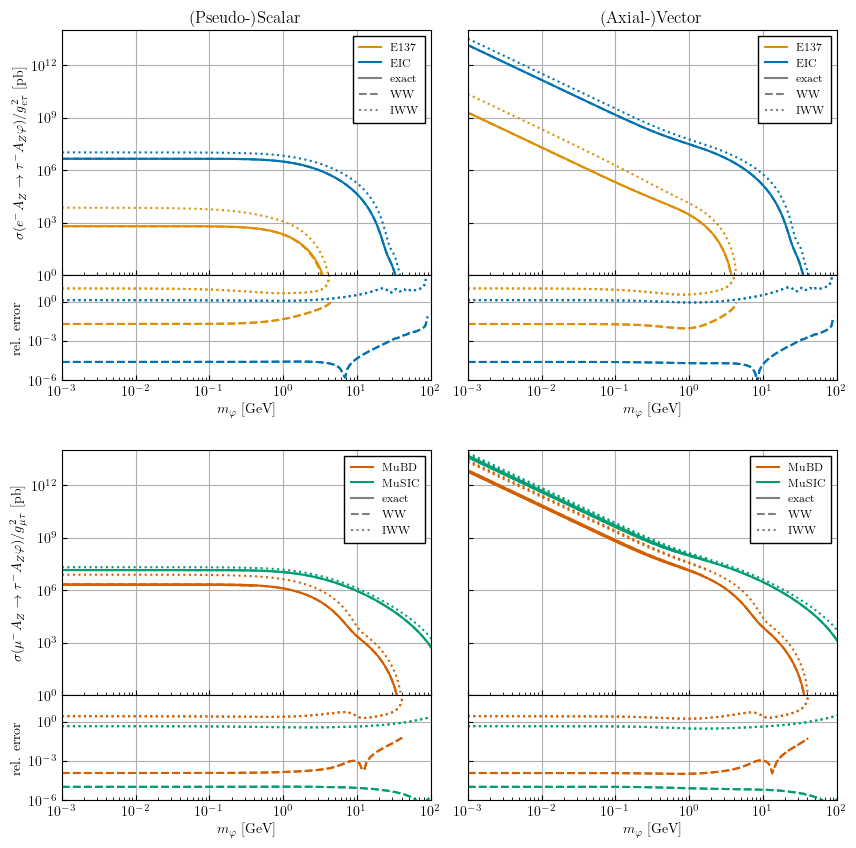

In [9]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods(['E137','EIC_Gold'], 'tau', sub_gs)

ax1.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])

ax2.set_ylim(1e-6, 1e2)
ax4.set_ylim(1e-6, 1e2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods(['MuCol','MuSIC'], 'tau', sub_gs)

ax5.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])

ax6.set_ylim(1e-6, 1e2)
ax8.set_ylim(1e-6, 1e2)

ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_tau.pdf')

## Lab Frame Distributions

In [10]:
@lru_cache
def dcrossx_eta_gamma(collider, params):
    
    v_nuc, E, masses = process_run_card(f'{collider}.txt', ['v_nuc', 'E', 'masses'])
    f = np.sqrt((1 + v_nuc)/(1 - v_nuc))
    
    shape = (len(masses), 1000)
    
    eta = np.empty(shape)
    gamma = np.empty(shape)
    dcrossx_deta = np.empty(shape)
    dcrossx_dgamma = np.empty(shape)

    for idx, m in enumerate(masses):
        e = np.linspace(-30, 30, 1000)
        eta[idx] = e
        g_max = max(1, E/(f*m)) + f * m/(4*E)
        g = np.logspace(1e-3, np.log10(1.2*g_max), 1000)
        gamma[idx] = g
        dcrossx_dgamma[idx], dcrossx_deta[idx] = lab_frame_distributions(collider, params + (m,), g, e)
        
    return gamma, eta, dcrossx_dgamma, dcrossx_deta

@lru_cache
def crossx_lab(collider, params, eta_min = -np.inf, eta_max = np.inf, units = 'pb'):
    if units == 'pb':
        return (hc2_fbGeV2/1000)*crossx_lab(collider, params, eta_min, eta_max, units = 'GeV')
    if units == 'fb':
        return hc2_fbGeV2*crossx_lab(collider, params, eta_min, eta_max, units = 'GeV')
    _, eta, _, dcrossx_deta = dcrossx_eta_gamma(collider, params)
    return np.trapz(dcrossx_deta*(eta > eta_min)*(eta < eta_max), x = eta)

In [11]:
def smooth(y, x, xscale = 'lin', tol = 500):
    if xscale == 'lin':
        x_ = x
        y_ = y
    elif xscale == 'log':
        x_ = np.log10(x)
        y_ = np.log10(y)
        
    dy_dx = np.gradient(y_, x_)
    d2y_dx2 = np.gradient(dy_dx, x_)
        
    #pick max, *then* average
    y_smooth = np.array([np.nanmax(y[max(i-20, 0):min(i+1, len(y))]) for i in range(len(y))])        
    y_smooth = np.where(np.abs(d2y_dx2) > tol, y_smooth, y)
    y_smooth = np.array([np.nanmean(y_smooth[max(i-5, 0):min(i+5, len(y))]) for i in range(len(y))])

    return y_smooth
        

# If xs and ys are arrays of independent and corresponding dependent variables, this 
# effectively computes the envelope of every y(x). To do so, it first finds the pair
# (x0, y(x0)) which maximizes each y. Then, it appends the curves at the start and
# end.
def envelope(xs, ys, xscale = 'lin', smooth_y = False):
    
    x_min = np.min(xs[ys > 0])
    x_max = np.max(xs[ys > 0])
    
    if xscale == 'lin':
        x_env = np.linspace(x_min, x_max, 1000)
    elif xscale == 'log':
        x_env = np.logspace(np.log10(x_min), np.log10(x_max), 1000)
    
    x_nearest = []
    y_nearest = []
    for idx, (x, y) in enumerate(zip(xs, ys)):
        argmins = [np.argmin(np.abs(x-x_e)) for x_e in x_env]
        x_nearest.append(np.array([x[argmin] for argmin in argmins]))
        y_nearest.append(np.array([y[argmin] for argmin in argmins]))
    
    y_env = np.nanmax(y_nearest, axis = 0)
    if smooth_y:
        y_env = smooth(y_env, x_env, xscale = xscale, tol = 10)
    
    _, args = np.unique(y_env, return_index = True)
    y_env = y_env[sorted(args)]
    x_env = x_env[sorted(args)]
    
    return x_env, y_env
    
def eta_envelope(collider, params, idx_min = 0, idx_max = -1):
    _, etas, _, dcrossx_deta = dcrossx_eta_gamma(collider, params)
    cx = crossx_lab(collider, params, units = 'GeV')[idx_min:idx_max].reshape(-1, 1)
    return envelope(etas[idx_min:idx_max], dcrossx_deta[idx_min:idx_max]/cx, xscale = 'lin')

def gamma_envelope(collider, params, idx_min = 0, idx_max = -1):
    gams, _, dcrossx_dgam, _ = dcrossx_eta_gamma(collider, params)
    cx = crossx_lab(collider, params, units = 'GeV')[idx_min:idx_max].reshape(-1, 1)
    return envelope(gams[idx_min:idx_max], dcrossx_dgam[idx_min:idx_max]/cx, xscale = 'log', smooth_y = True)

In [12]:
def plot_distribution(collider, params, idcs, plot_envelope = True, which = 'eta', color = None, ax = None):
    masses = process_run_card(f'{collider}.txt', 'masses')
    if which == 'eta':
        _, xs, _, ys = dcrossx_eta_gamma(collider, params)
        ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)
        if plot_envelope:
            x_env, y_env = eta_envelope(collider, params, idcs[0], idcs[-1]+1)
    elif which == 'gamma':
        xs, _, ys, _ = dcrossx_eta_gamma(collider, params)
        ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)
        if plot_envelope:
            x_env, y_env = gamma_envelope(collider, params, idcs[0], idcs[-1]+1)            
    
    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[collider]
    
    if plot_envelope:
        ax.fill_between(x_env, y_env, color = color, alpha = 0.1)
        ax.plot(x_env, y_env, color = color, linestyle = 'dashed')
        
    for idx in idcs:
        ax.plot(xs[idx], ys[idx], color = color)
        
    xmin = x_env[y_env > 0].min()
    xmax = x_env[y_env > 0].max()    
    
    plt.xlim(xmin, xmax)
    
    ax.tick_params(which = 'both', direction = 'in')
    
    return ax
    
def plot_distribution_average(collider, params, which = 'eta', color = None, ax = None):
    masses = process_run_card(f'{collider}.txt', 'masses')
    if which == 'eta':
        _, xs, _, ys = dcrossx_eta_gamma(collider, params)
        ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)
    elif which == 'gamma':
        xs, _, ys, _ = dcrossx_eta_gamma(collider, params)
        ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)          
    
    x_avg = np.trapz(xs*ys, x = xs)
    x_std = np.sqrt(np.trapz((xs - x_avg.reshape(-1, 1))**2 * ys, x = xs))
    
    if not ax:
        ax = plt.gca()
        
    if not color:
        color = color_dict[collider]
        
    ax.fill_between(masses, x_avg - x_std, x_avg + x_std, color = color, alpha = 0.1)
    ax.plot(masses, x_avg-x_std, color = color)
    ax.plot(masses, x_avg+x_std, color = color)
    ax.plot(masses, x_avg, color = color, linestyle = 'dotted', alpha = 0.5)
    
    #connect the edges
    endpt = np.min(np.where(np.isnan(x_avg) + (x_avg == x_avg[-1]))) - 1
    xmin = (x_avg - x_std)[endpt]
    xmax = (x_avg + x_std)[endpt]
    ax.plot([masses[endpt], masses[endpt]], [xmin, xmax], color = color)
    
    return ax

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/382342889.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(dcrossx_deta*(eta > eta_min)*(eta < eta_max), x = eta)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:5: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)


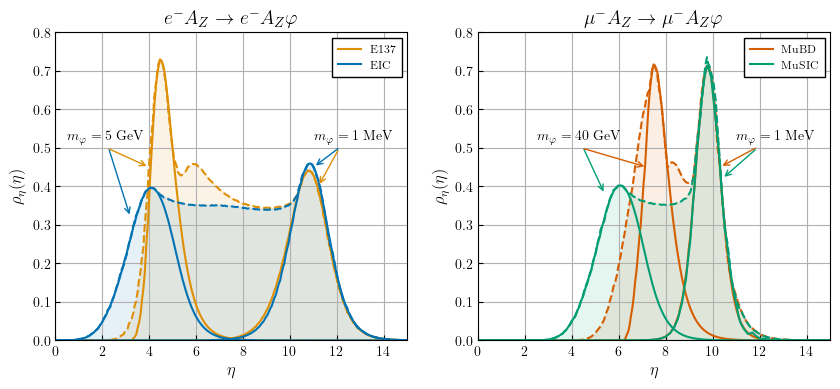

In [13]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('E137', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'eta')
plot_distribution('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'eta')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (11, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (12.1, 0.5),
             xy = (11.2, 0.4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (0.5, 0.52),
             xy = (3.2, 0.32),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (2.2, 0.5),
             xy = (4, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\eta$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax1.set_xlim(0, 15)
ax1.set_ylim(0, 0.8)
ax1.grid()

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuCol', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')
plot_distribution('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')


ax2.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (10.3, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))
ax2.annotate('',
             xytext = (11.9, 0.5),
             xy = (10.4, 0.42),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))


ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (2.5, 0.52),
             xy = (5.4, 0.38),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (4.4, 0.5),
             xy = (7.2, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\eta$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)


ax2.set_xlim(0, 15)
ax2.set_ylim(0, 0.8)
ax2.grid()

plt.savefig('figures/chapter4/eta_distributions_diagonal.pdf', format = 'pdf')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/382342889.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(dcrossx_deta*(eta > eta_min)*(eta < eta_max), x = eta)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:5: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)


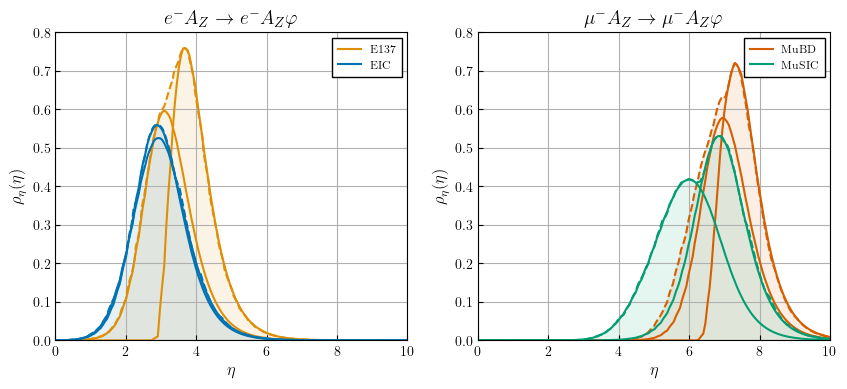

In [14]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('E137', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'eta')
plot_distribution('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'eta')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\eta$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax1.set_xlim(0, 10)
ax1.set_ylim(0, 0.8)
ax1.grid()

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuCol', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')
plot_distribution('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')


ax2.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\eta$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 0.8)
ax2.grid()

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:40: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  x_avg = np.trapz(xs*ys, x = xs)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  x_std = np.sqrt(np.trapz((xs - x_avg.reshape(-1, 1))**2 * ys, x = xs))


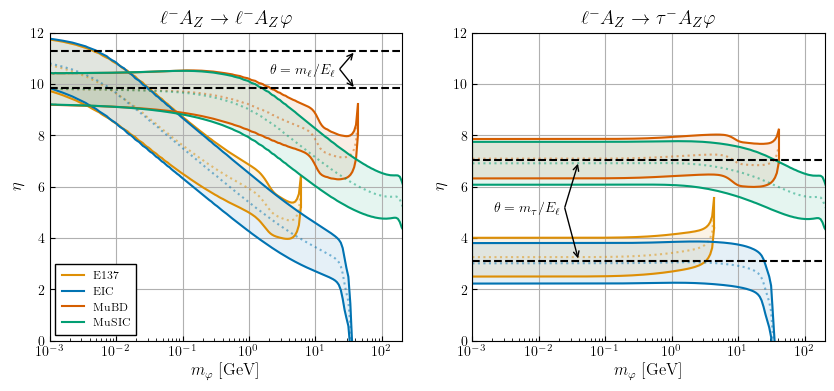

In [15]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta')

ax1.text(2.1, 10.4, '$\\theta = m_\\ell / E_\\ell$', color = 'black')
ax1.annotate('', (40, 9.8), (22, 10.65),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (40, 11.3), (22, 10.52),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax1.axhline(-np.log(np.tan(5.11e-4/(2*20))), color = 'black', linestyle = 'dashed')
ax1.axhline(-np.log(np.tan(0.106/(2*1000))), color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\eta$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(0, 12)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')


ax2.text(2.1e-3, 5, '$\\theta = m_\\tau / E_\\ell$', color = 'black')
ax2.annotate('', (4e-2, 3.1), (2.4e-2, 5.27),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (4e-2, 7), (2.4e-2, 5.10),
             arrowprops = dict(arrowstyle = '->', color = 'black'))


ax2.axhline(-np.log(np.tan(1.77/(2*20))), color = 'black', linestyle = 'dashed')
ax2.axhline(-np.log(np.tan(1.77/(2*1000))), color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\eta$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')

ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(0, 12)

plt.savefig('figures/chapter4/average_eta.pdf', format = 'pdf')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:10: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)


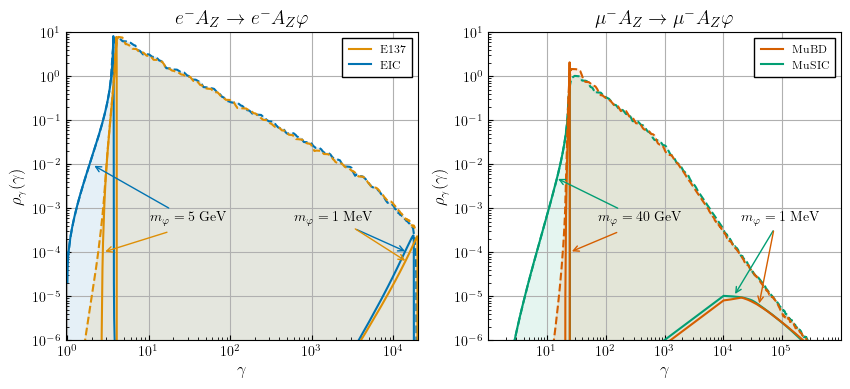

In [16]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'gamma')
plot_distribution('E137', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'gamma')

ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (600, 5e-4),
             xy = (1.5e4, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (3.2e3, 3.7e-4),
             xy = (1.5e4, 6e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (10.2, 5e-4),
             xy = (2, 1e-2),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (18, 3e-4),
             xy = (2.7, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))


ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\gamma$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.95, 2e4)
ax1.set_ylim(1e-6, 1e1)

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')
plot_distribution('MuCol', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (2e4, 5e-4),
             xy = (1.5e4, 1e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (7.3e4, 3.5e-4),
             xy = (4e4, 6e-6),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (73, 5e-4),
             xy = (14, 5e-3),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (170, 3e-4),
             xy = (24, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))


ax2.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\gamma$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax2.grid()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e-6, 1e1)

plt.savefig('figures/chapter4/gamma_distributions_diagonal.pdf', format = 'pdf')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:10: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)


(1e-07, 10.0)

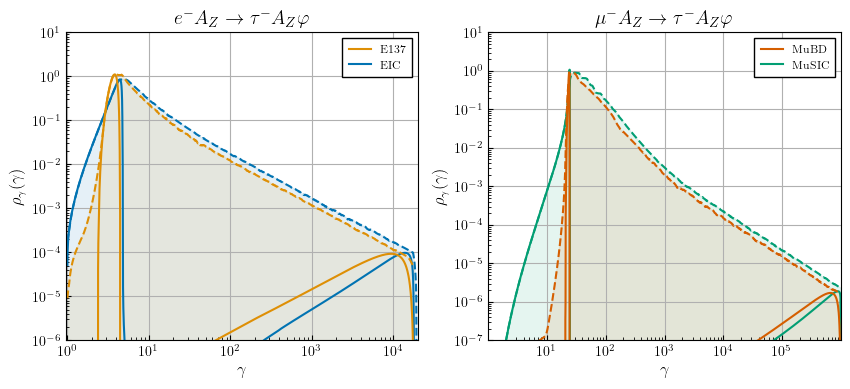

In [17]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'gamma')
plot_distribution('E137', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'gamma')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\gamma$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.95, 2e4)
ax1.set_ylim(1e-6, 1e1)

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')
plot_distribution('MuCol', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')


ax2.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax2.set_title('$\\mu^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\gamma$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax2.grid()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e-7, 1e1)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:43: RuntimeWarning: invalid value encountered in divide
  ys = ys/crossx_lab(collider, params, units = 'GeV').reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  x_avg = np.trapz(xs*ys, x = xs)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_28943/3828147757.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  x_std = np.sqrt(np.trapz((xs - x_avg.reshape(-1, 1))**2 * ys, x = xs))


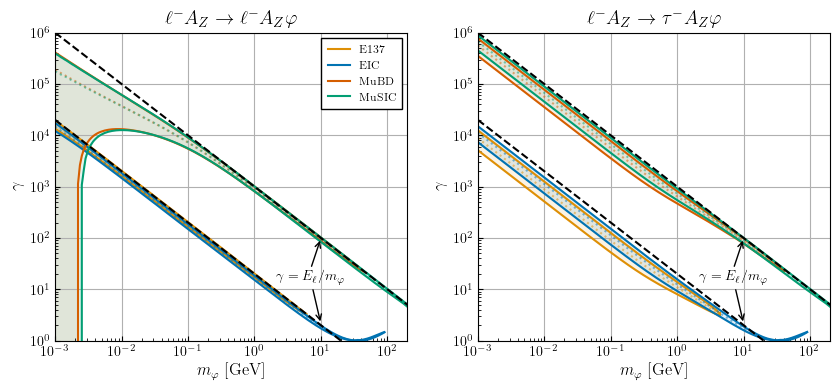

In [18]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma')

#ax1.text(2.1, 20, '$\\gamma = E_\\ell / m_\\ell$', color = 'black')
ax1.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

masses = np.array(process_run_card('E137.txt', 'masses'))

ax1.plot(masses, 20/masses, color = 'black', linestyle = 'dashed')
ax1.plot(masses, 1000/masses, color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\gamma$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(1e0, 1e6)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')


ax2.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax2.plot(masses, 20/masses, color = 'black', linestyle = 'dashed')
ax2.plot(masses, 1000/masses, color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(1e0, 1e6)

plt.savefig('figures/chapter4/average_gamma.pdf', format = 'pdf')

In [19]:
@liru_cache
def dcrossx_eta_gamma(collider, params):
    
    v_nuc, E, masses = process_run_card(f'{collider}.txt', ['v_nuc', 'E', 'masses'])

    lf = params[0]
    mf = ml[0]*(lf == 'e') + ml[1]*(lf == 'mu') + ml[2]*(lf == 'tau')
    
    f = np.sqrt((1 + v_nuc)/(1 - v_nuc))
    
    shape = (len(masses), 1000)
    
    eta = np.empty(shape)
    gamma = np.empty(shape)
    dcrossx_deta = np.empty(shape)
    dcrossx_dgamma = np.empty(shape)

    for idx, m in enumerate(masses):
        e = np.linspace(-30, 30, 1000)
        eta[idx] = e
        g_max = max(1, E/(f*ml)) + f * ml/(4*E)
        g = np.logspace(1e-3, np.log10(1.2*g_max), 1000)
        gamma[idx] = g
        dcrossx_dgamma[idx], dcrossx_deta[idx] = lab_frame_distributions(collider, params + (m,), g, e)
        
    return gamma, eta, dcrossx_dgamma, dcrossx_deta

NameError: name 'liru_cache' is not defined

## Rough Limits

In [ ]:
def read_LFV_limits(file, lepton_tuple):
    df = pd.read_csv(file, index_col = 0)
    m = df.index.to_numpy(dtype = np.float64)
    limit = df[str(lepton_tuple)].to_numpy(dtype = np.float64)
    return m, limit

In [ ]:
m, limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_scalar_limits.csv', (0, 0, 2))
m, limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_scalar_limits.csv', (0, 0, 2))

In [ ]:
m, PC_limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_scalar_limits.csv', (0, 0, 2))
m, chiral_limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_scalar_limits.csv', (0, 0, 2))

plt.plot(m, PC_limit, color = 'grey')
plt.plot(m, chiral_limit, color = 'grey', linestyle = 'dashed')

minimum = np.minimum(PC_limit, chiral_limit)

plt.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)

A_Au = process_run_card('EIC_Gold.txt', 'A')
A_Pb = process_run_card('MuSIC.txt', 'A')

#only plot for 
plot_colliders = colliders[1:]
luminosities = np.array([100/A_Au, 100/A_Pb, 1e18 * 6.592e-17])
efficiency = np.array([0.01]*3)
params = [('tau', 'scalar', 1.0, 'exact', False)]*3
eta_min = [-3.5, -6, 2]
eta_max = [3.5, 6, 30]

cross_sections = np.array([crossx_lab(plot_colliders[idx],
                                      params[idx],
                                      eta_min = eta_min[idx],
                                      eta_max = eta_max[idx],
                                      units = 'fb') for idx in range(3)])

coupling_limits = np.sqrt(3.5/((efficiency*luminosities).reshape(-1, 1)*cross_sections))

masses = process_run_card('MuSIC.txt', 'masses')
plt.plot(masses, coupling_limits[0], color = colors[0], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[0],
                 1e10,
                 color = colors[0],
                 alpha = 0.2)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 2e2)
plt.ylim(1e-6, 1e0)

In [ ]:
m, PC_limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_scalar_limits.csv', (1, 1, 2))
m, chiral_limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_scalar_limits.csv', (1, 1, 2))

minimum = np.minimum(PC_limit, chiral_limit)

plt.plot(m, PC_limit, color = 'grey')
plt.plot(m, chiral_limit, color = 'grey', linestyle = 'dashed')

plt.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)

A_Au = process_run_card('EIC_Gold.txt', 'A')
A_Pb = process_run_card('MuSIC.txt', 'A')

#only plot for 
plot_colliders = colliders[1:]
luminosities = np.array([100/A_Au, 100/A_Pb, 1e18 * 6.592e-17])
efficiency = np.array([0.01]*3)
params = [('tau', 'scalar', 1.0, 'exact', False)]*3
eta_min = [-3.5, -6, 2]
eta_max = [3.5, 6, 30]

cross_sections = np.array([crossx_lab(plot_colliders[idx],
                                      params[idx],
                                      eta_min = eta_min[idx],
                                      eta_max = eta_max[idx],
                                      units = 'fb') for idx in range(3)])

coupling_limits = np.sqrt(3.5/((efficiency*luminosities).reshape(-1, 1)*cross_sections))

masses = process_run_card('MuSIC.txt', 'masses')

plt.plot(masses, coupling_limits[2], color = colors[3], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[2],
                 1e10,
                 color = colors[3],
                 alpha = 0.2)
plt.plot(masses, coupling_limits[1], color = colors[2], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[1],
                 1e10,
                 color = colors[2],
                 alpha = 0.2)


plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 2e2)
plt.ylim(1e-6, 1e0)

In [ ]:
m, PC_limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_scalar_limits.csv', (0, 0, 1))
m, chiral_limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_scalar_limits.csv', (0, 0, 1))

plt.plot(m, PC_limit, color = 'grey')
#plt.plot(m, chiral_limit, color = 'grey', linestyle = 'dashed')

minimum = np.minimum(PC_limit, chiral_limit)

m, PC_limit = read_LFV_limits('dipole_form_factors/data/mdm_PC_scalar_limits.csv', (1, 1, 0))
m, chiral_limit = read_LFV_limits('dipole_form_factors/data/mdm_chiral_scalar_limits.csv', (1, 1, 0))

minimum = np.minimum(PC_limit, minimum)
minimum = np.minimum(chiral_limit, minimum)

#plt.plot(m, PC_limit, color = 'black')
plt.plot(m, chiral_limit, color = 'grey', linestyle = 'dashed')

plt.fill_between(m, minimum, 1e10, color = 'yellow', alpha = 0.05)

A_Au = process_run_card('EIC_Gold.txt', 'A')
A_Pb = process_run_card('MuSIC.txt', 'A')

#only plot for 
plot_colliders = colliders[1:]
luminosities = np.array([100/A_Au, 100/A_Pb, 1e18 * 6.592e-17])
efficiency = np.array([0.01]*3)
params = [('mu', 'scalar', 1.0, 'exact', False)] + [('e', 'scalar', 1.0, 'exact', False)]*2
eta_min = [-3.5, -6, 2]
eta_max = [3.5, 6, 30]

cross_sections = np.array([crossx_lab(plot_colliders[idx],
                                      params[idx],
                                      eta_min = eta_min[idx],
                                      eta_max = eta_max[idx],
                                      units = 'fb') for idx in range(3)])

coupling_limits = np.sqrt(3.5/((efficiency*luminosities).reshape(-1, 1)*cross_sections))

masses = process_run_card('MuSIC.txt', 'masses')
plt.plot(masses, coupling_limits[0], color = colors[0], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[0],
                 1e10,
                 color = colors[0],
                 alpha = 0.2)

plt.plot(masses, coupling_limits[2], color = colors[3], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[2],
                 1e10,
                 color = colors[3],
                 alpha = 0.2)
plt.plot(masses, coupling_limits[1], color = colors[2], linewidth = 3)
plt.fill_between(masses,
                 coupling_limits[1],
                 1e10,
                 color = colors[2],
                 alpha = 0.2)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 2e2)
plt.ylim(1e-6, 1e0)